In [8]:
#载入接下来分析用的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB

In [3]:
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

In [30]:
data = pd.read_csv('../dataset/iqiyi_title_info.csv', usecols=['title', 'category'])
data.head()

,title,category
0,《余罪》张一山和嫂子偷情 被大哥发现了,欢乐精选
1,笑囧一族497：美女强吻醉酒帅哥,欢乐精选
2,笑囧一族432：美女入洞房啪啪啪，万万没想到！,欢乐精选
3,街头整蛊僵尸婴儿 骚年你吓尿了吗,欢乐精选
4,据说，男人强吻女人只有这两种结果,欢乐精选


In [31]:
import jieba
data['words'] = data.title.apply(lambda x: " ".join(jieba.cut(x)))

In [32]:
data.head()

,title,category,words
0,《余罪》张一山和嫂子偷情 被大哥发现了,欢乐精选,《 余罪 》 张一山 和 嫂子 偷情 被 大哥 发现 了
1,笑囧一族497：美女强吻醉酒帅哥,欢乐精选,笑 囧 一族 497 ： 美女 强吻 醉酒 帅哥
2,笑囧一族432：美女入洞房啪啪啪，万万没想到！,欢乐精选,笑 囧 一族 432 ： 美女 入 洞房 啪啪 啪 ， 万万 没想到 ！
3,街头整蛊僵尸婴儿 骚年你吓尿了吗,欢乐精选,街头 整 蛊 僵尸 婴儿 骚年 你 吓 尿 了 吗
4,据说，男人强吻女人只有这两种结果,欢乐精选,据说 ， 男人 强吻 女人 只有 这 两种 结果


In [33]:
data.category.unique()

array(['欢乐精选', '娱乐八卦', nan, '搞笑短片', '影视剧吐槽', '雷人囧事', '爆笑节目', '萌宠', '童趣',
       '奇闻趣事', '恶搞配音', '相声', '小品', '猎奇', '啪啪奇'], dtype=object)

<IPython.core.display.Javascript object>


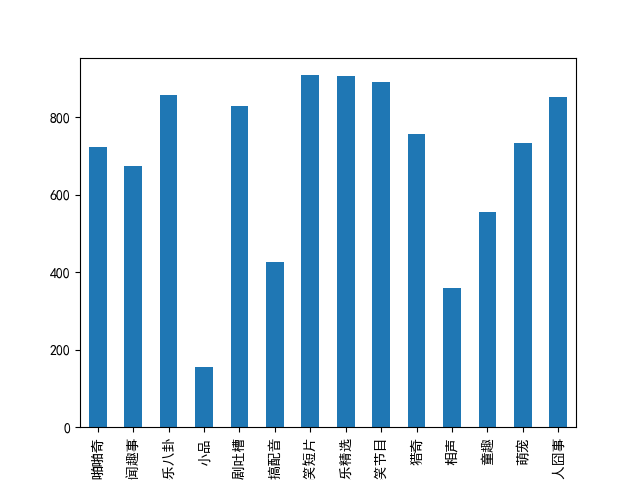

In [34]:

labels = data.groupby('category')['category'].count()
labels.plot(kind='bar')

plt.show()

### 对文本数据的正文字段进行分词，这里是在Linux上运行的，可以开启jieba的并行分词模式，分词速度是平常的好多倍，具体看你的CPU核心数。

In [35]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """对数损失度量（Logarithmic Loss  Metric）的多分类版本。
    :param actual: 包含actual target classes的数组
    :param predicted: 分类预测结果矩阵, 每个类别都有一个概率
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

### 接下来用scikit-learn中的LabelEncoder将文本标签（Text Label）转化为数字(Integer)

In [13]:
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(list(data.category.values))
y

array([8, 8, 8, ..., 1, 1, 1], dtype=int64)

### 在进一步研究之前，我们必须将数据分成训练和验证集。 我们可以使用scikit-learn的model_selection模块中的train_test_split来完成它。

In [36]:
xtrain, xvalid, ytrain, yvalid = train_test_split(data.words, y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)
print (xtrain.shape)
print (xvalid.shape)

(7716,)
(1930,)


# 构建基础模型（Basic Models）
让我们先创建一个非常基础的模型。

这个非常基础的模型（very first model）基于 TF-IDF (Term Frequency - Inverse Document Frequency)+逻辑斯底回归（Logistic Regression）。

笔者将scikit-learn中的TfidfVectorizer类稍稍改写下，以便将文本中的数字特征统一表示成"#NUMBER"，达到一定的降噪效果。

In [40]:
def number_normalizer(tokens):
    """ 将所有数字标记映射为一个占位符（Placeholder）。
    对于许多实际应用场景来说，以数字开头的tokens不是很有用，
    但这样tokens的存在也有一定相关性。 通过将所有数字都表示成同一个符号，可以达到降维的目的。
    """
    return ("#NUMBER" if token[0].isdigit() else token for token in tokens)


class NumberNormalizingVectorizer(TfidfVectorizer):
    def build_tokenizer(self):
        tokenize = super(NumberNormalizingVectorizer, self).build_tokenizer()
        return lambda doc: list(number_normalizer(tokenize(doc)))


In [37]:
def load_stop_words():
    """
        加载停用词
    """
    stopwords1 = [line.rstrip() for line in open('../stop_words/中文停用词库.txt', 'r', encoding='utf-8')]
    stopwords2 = [line.rstrip() for line in open('../stop_words/哈工大停用词表.txt', 'r', encoding='utf-8')]
    stopwords3 = [line.rstrip() for line in open('../stop_words/四川大学机器智能实验室停用词库.txt', 'r', encoding='utf-8')]
    stopwords = stopwords1 + stopwords2 + stopwords3

    return stopwords

In [38]:
#加载停用词
stopwords = load_stop_words()
len(stopwords)

2489

In [41]:
# 利用刚才创建的NumberNormalizingVectorizer类来提取文本特征，注意里面各类参数的含义，自己去sklearn官方网站找教程看


tfv = NumberNormalizingVectorizer(min_df=3,  
                                  max_df=0.5,
                                  max_features=None,                 
                                  ngram_range=(1, 2), 
                                  use_idf=True,
                                  smooth_idf=True,
                                  stop_words = stopwords)

# 使用TF-IDF来fit训练集和测试集（半监督学习）
tfv.fit(list(xtrain) + list(xvalid))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)

E:\Anaconda3\envs\python3.6\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['#NUMBER', 'lex', 'ｌｉ', 'ｚｘｆｉｔｌ'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [45]:
#利用提取的TFIDF特征来fit一个简单的Logistic Regression 
clf = LogisticRegression(C=1.0,solver='lbfgs',multi_class='multinomial')
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))
# print(classification_report(predictions, yvalid))

logloss: 1.718 
